In [8]:
***REMOVED***
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf


physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(
 #   physical_devices[0], True
#)
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
df = pd.read_csv("../tags_processed_stages/dafre_tags.csv")
num_classes = df['tags_cat4'].nunique()
print(num_classes)

3486


In [10]:
len(df)

463437

In [11]:

class_counts = df['tags_cat4'].value_counts()
df_filtered = df[df['tags_cat4'].isin(class_counts[class_counts >= 2].index)]
train_df, temp_df = train_test_split(df_filtered, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

common_classes = set(train_df['tags_cat4']).intersection(set(val_df['tags_cat4']), set(test_df['tags_cat4']))

train_df = train_df[train_df['tags_cat4'].isin(common_classes)]
val_df = val_df[val_df['tags_cat4'].isin(common_classes)]
test_df = test_df[test_df['tags_cat4'].isin(common_classes)]
print(val_df['tags_cat4'].nunique())

3095


In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='../fullMin256/', 
    x_col='dir', 
    y_col='tags_cat4', 
    target_size=(150, 150), 
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='../fullMin256/',
    x_col='dir',
    y_col='tags_cat4',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='../fullMin256/',
    x_col='dir',
    y_col='tags_cat4',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 366503 validated image filenames belonging to 3095 classes.
Found 46064 validated image filenames belonging to 3095 classes.
Found 46028 validated image filenames belonging to 3095 classes.


In [15]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0, width_factor=0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
])
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
model = Sequential()

model.add(data_augmentation)
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3095, activation='softmax'))



#model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=['accuracy'])

2024-01-31 19:46:57.811495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 19:46:57.811681: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 19:46:57.811727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 19:46:58.261145: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 19:46:58.261221: I external/local_xla/xla/stream_executor

2024-01-31 19:47:00.623456: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-31 19:47:00.854758: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-31 19:47:01.540286: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/100


2024-01-31 19:47:06.504238: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1b84b807f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 19:47:06.504288: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
I0000 00:00:1706748426.564046    2665 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/357 [==============================] - 54s 136ms/step - loss: 9.8905 - accuracy: 0.0150 - top_5_categorical_accuracy: 0.0312 - val_loss: 9.4439 - val_accuracy: 0.0368 - val_top_5_categorical_accuracy: 0.0861 - lr: 0.0050


/home/leogu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
357/357 [==============================] - 46s 129ms/step - loss: 9.3557 - accuracy: 0.0352 - top_5_categorical_accuracy: 0.0872 - val_loss: 8.8841 - val_accuracy: 0.0417 - val_top_5_categorical_accuracy: 0.1215 - lr: 0.0050
Epoch 3/100
357/357 [==============================] - 44s 122ms/step - loss: 8.9973 - accuracy: 0.0386 - top_5_categorical_accuracy: 0.0991 - val_loss: 8.5582 - val_accuracy: 0.0535 - val_top_5_categorical_accuracy: 0.1236 - lr: 0.0050
Epoch 4/100
357/357 [==============================] - 45s 124ms/step - loss: 8.7027 - accuracy: 0.0428 - top_5_categorical_accuracy: 0.1092 - val_loss: 8.3376 - val_accuracy: 0.0514 - val_top_5_categorical_accuracy: 0.1306 - lr: 0.0050
Epoch 5/100
357/357 [==============================] - 44s 123ms/step - loss: 8.4883 - accuracy: 0.0404 - top_5_categorical_accuracy: 0.1134 - val_loss: 8.1138 - val_accuracy: 0.0618 - val_top_5_categorical_accuracy: 0.1368 - lr: 0.0050
Epoch 6/100
357/357 [==============================]

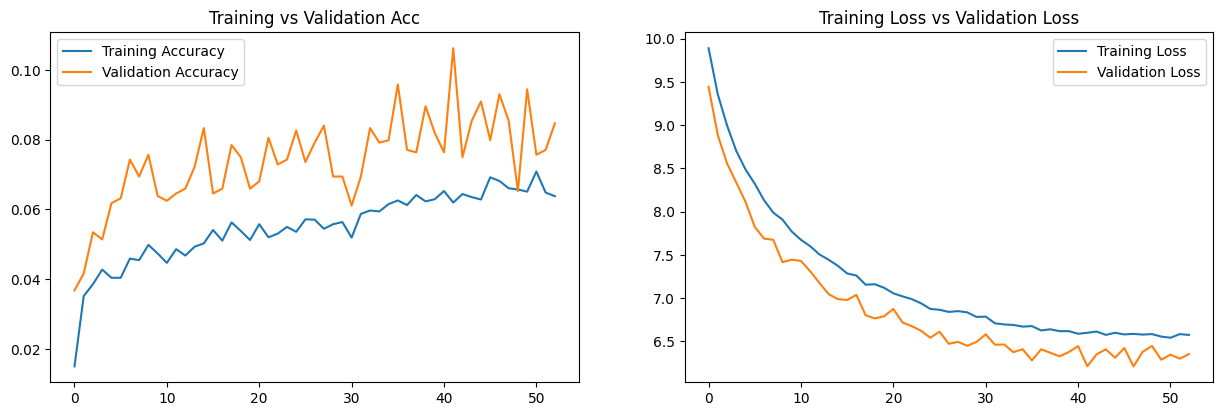

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5 , mode='min', verbose=1)
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')])
#model.build(150, 150, 3)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100, 
    verbose=1,
    steps_per_epoch=len(train_generator)/32,
    validation_steps=len(validation_generator)/32,
    callbacks=[checkpoint, early_stopping, reduce_lr])  


tra_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(tra_acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend()
plt.title("Training vs Validation Acc")

tra_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(2,2,2)
plt.plot(tra_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.show()


In [20]:
base_model.trainable = True

total_layers = len(base_model.layers)
increment = 11

sgd_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.005, momentum=0.9)

for i in range(total_layers - increment, 0, -increment):
    for layer in base_model.layers[:i]:
        layer.trainable = False
    for layer in base_model.layers[i:]:
        layer.trainable = True

    model.compile(optimizer=sgd_optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')])

    # Fit the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=1000,  
        verbose=1,
        steps_per_epoch=len(train_generator)/32,
        validation_steps=len(validation_generator)/32,
        initial_epoch=0 if i == total_layers - increment else history.epoch[-1],  
        callbacks=[checkpoint, early_stopping, reduce_lr])

tra_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(tra_acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend()
plt.title("Training vs Validation Acc")

tra_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(2,2,2)
plt.plot(tra_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.show()


Epoch 1/1000
357/357 [==============================] - 49s 127ms/step - loss: 3.9856 - accuracy: 0.3034 - top_5_categorical_accuracy: 0.5142 - val_loss: 3.8699 - val_accuracy: 0.3104 - val_top_5_categorical_accuracy: 0.5229 - lr: 0.0050
Epoch 2/1000
357/357 [==============================] - 44s 124ms/step - loss: 4.0566 - accuracy: 0.2985 - top_5_categorical_accuracy: 0.5003 - val_loss: 3.8145 - val_accuracy: 0.3208 - val_top_5_categorical_accuracy: 0.5333 - lr: 0.0050
Epoch 3/1000
357/357 [==============================] - 46s 128ms/step - loss: 4.0328 - accuracy: 0.2986 - top_5_categorical_accuracy: 0.5040 - val_loss: 3.9589 - val_accuracy: 0.3000 - val_top_5_categorical_accuracy: 0.5250 - lr: 0.0050
Epoch 4/1000
357/357 [==============================] - 44s 124ms/step - loss: 4.0523 - accuracy: 0.2980 - top_5_categorical_accuracy: 0.4998 - val_loss: 3.8984 - val_accuracy: 0.3229 - val_top_5_categorical_accuracy: 0.5229 - lr: 0.0050
Epoch 5/1000
358/357 [==========================

/home/leogu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


357/357 [==============================] - 57s 159ms/step - loss: 3.8528 - accuracy: 0.3181 - top_5_categorical_accuracy: 0.5344 - val_loss: 3.5457 - val_accuracy: 0.3583 - val_top_5_categorical_accuracy: 0.5722 - lr: 1.0000e-05
Epoch 37/1000
357/357 [==============================] - 61s 170ms/step - loss: 3.8914 - accuracy: 0.3180 - top_5_categorical_accuracy: 0.5278 - val_loss: 3.6249 - val_accuracy: 0.3549 - val_top_5_categorical_accuracy: 0.5604 - lr: 1.0000e-05
Epoch 38/1000
357/357 [==============================] - 65s 183ms/step - loss: 3.8438 - accuracy: 0.3196 - top_5_categorical_accuracy: 0.5323 - val_loss: 3.6483 - val_accuracy: 0.3486 - val_top_5_categorical_accuracy: 0.5618 - lr: 1.0000e-05
Epoch 39/1000
357/357 [==============================] - 60s 168ms/step - loss: 3.8422 - accuracy: 0.3253 - top_5_categorical_accuracy: 0.5251 - val_loss: 3.6914 - val_accuracy: 0.3333 - val_top_5_categorical_accuracy: 0.5472 - lr: 1.0000e-05
Epoch 40/1000
357/357 [===================

KeyboardInterrupt: 

In [ ]:
for layer in base_model.layers:
    layer.trainable = True
model.compile(optimizer=sgd_optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy',
                tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')])
history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=1000,  
        verbose=1,
        steps_per_epoch=len(train_generator)/32,
        validation_steps=len(validation_generator)/32,
        initial_epoch=0 if i == total_layers - increment else history.epoch[-1],  
        callbacks=[checkpoint, early_stopping, reduce_lr])
 

In [ ]:

tra_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(tra_acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend()
plt.title("Training vs Validation Acc")

tra_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(2,2,2)
plt.plot(tra_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.show()
model.save()